# Power demand prediction

$$
\newcommand{\eg}{{\it e.g.}}
\newcommand{\ie}{{\it i.e.}}
\newcommand{\argmin}{\operatornamewithlimits{argmin}}
\newcommand{\mc}{\mathcal}
\newcommand{\mb}{\mathbb}
\newcommand{\mf}{\mathbf}
\newcommand{\minimize}{{\text{minimize}}}
\newcommand{\diag}{{\text{diag}}}
\newcommand{\cond}{{\text{cond}}}
\newcommand{\rank}{{\text{rank }}}
\newcommand{\range}{{\mathcal{R}}}
\newcommand{\null}{{\mathcal{N}}}
\newcommand{\tr}{{\text{trace}}}
\newcommand{\dom}{{\text{dom}}}
\newcommand{\dist}{{\text{dist}}}
\newcommand{\R}{\mathbf{R}}
\newcommand{\SM}{\mathbf{S}}
\newcommand{\ball}{\mathcal{B}}
\newcommand{\bmat}[1]{\begin{bmatrix}#1\end{bmatrix}}
\newcommand{\loss}{\ell}
\newcommand{\eloss}{\mc{L}}
\newcommand{\abs}[1]{| #1 |}
\newcommand{\norm}[1]{\| #1 \|}
\newcommand{\tp}{T}
$$

__<div style="text-align: right"> EE370: Software lab, Kyung Hee University. </div>__
_<div style="text-align: right"> Jong-Han Kim (jonghank@khu.ac.kr) </div>_

Power utilities need to predict the power demanded by consumers.
A possible predictor is an _auto-regressive_ (AR) model, 
which predicts power demands based on a history of power demand data, 
$p_t$ for $t = 1, \dots, T$. Here, $p_t$ is the power usage 
in kilowatt hours (kWh) during time interval $t$. 

The AR predictor uses standardized power data $z_t$ to predict future power demands as 
an affine function of historical power data. In particular, we set

$$
x^i = \bmat{1 & z_i & \cdots & z_{i + (h - 1)}}, \qquad y^i = z_{h + i}, \qquad i = 1, \dots, T - h,
$$

and train a linear predictor model

\begin{align*}
  \hat{y}^i &= \hat{z}_{h+i} \\
  &= \theta_1 + \theta_2 z_i + \cdots + \theta_{h+1} z_{i+(h-1)}\\
  &= \theta^Tx^i
\end{align*}

such that your choise of $\theta \in \R^{h + 1}$ best explains the observed data, $\hat{y}^i\approx y^i$ . That way you can predict the future power demands as follows.

\begin{align*}
\hat{z}_{h + i+1} &= \theta^Tx^{i+1} \\
&= \theta_1 + \theta_2 z_{i+1} + \cdots + \theta_{h+1} z_{i+h}
\end{align*}

You will select  parameter vector $\theta \in \R^{h + 1}$. 



The following cell downloads $p_t$, for $t = 1, \dots, T$ with $T=21960$, the hourly electric power demands (in kWh) for California between July 2015 and December 2017. In this section, we will find the optimal AR predictor that best explains the given data

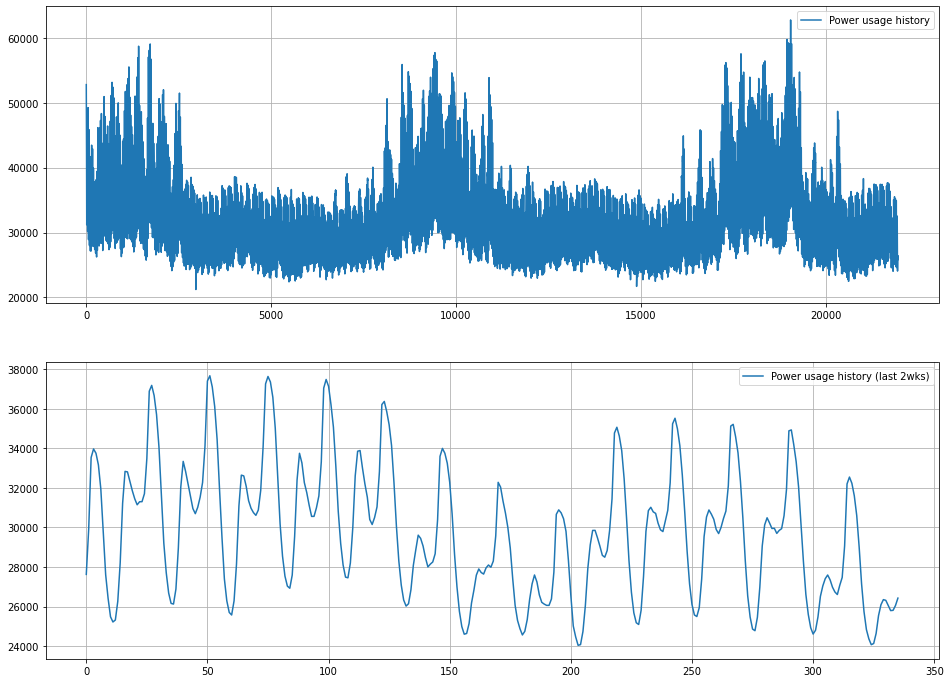

In [170]:
import numpy as np
import matplotlib.pyplot as plt

p = np.loadtxt('http://jonghank.github.io/ee370/files/power_history.csv', delimiter=',')
T = len(p)

plt.figure(figsize=(16,12))
plt.subplot(211)
plt.plot(p, label='Power usage history')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(p[-24*14:], label='Power usage history (last 2wks)')
plt.legend()
plt.grid()
plt.show()

**(Problem 1)** First standardize your data. In other words, find

$$
z_t = \frac{p_t - \bar{p}}{\sigma_p}
$$

where $\bar{p}$ and $\sigma_p$ represent the mean and the standard deviation of$p_1, \dots, p_T$ 

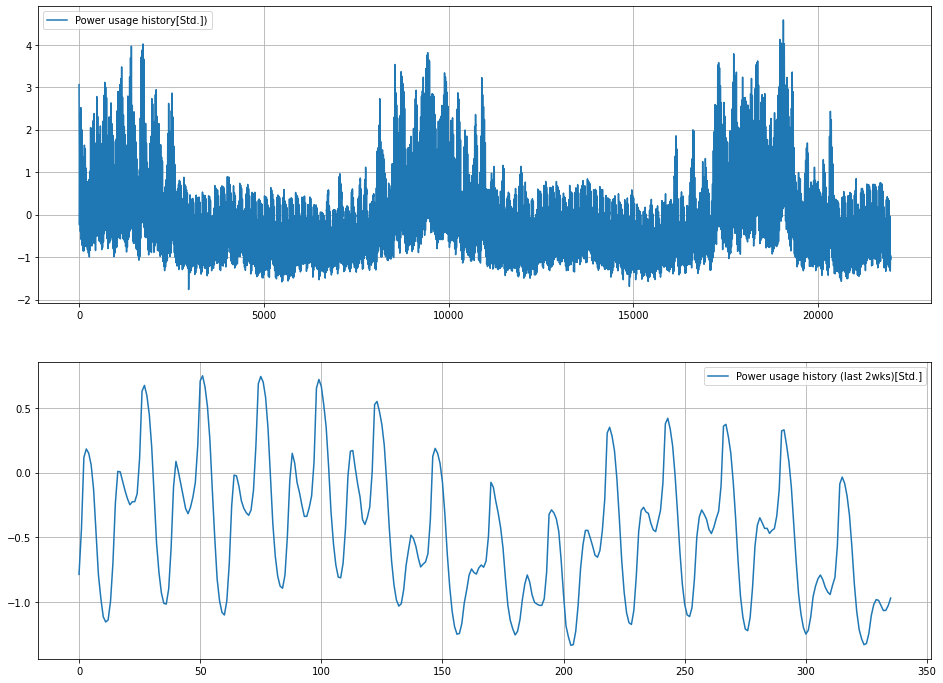

In [171]:
p_mean = np.mean(p)
p_std = np.std(p)

z=(p-p_mean)/p_std #Z 설정.

plt.figure(figsize=(16,12))
plt.subplot(211)
plt.plot(z, label='Power usage history[Std.])')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(z[-24*14:], label='Power usage history (last 2wks)[Std.]')
plt.legend()
plt.grid()
plt.show()

**(Problem 2)** With $h=336$ (corresponding to two weeks of data), build your feasures, $x^i$, and labels, $y^i$, for $i = 1, \dots, T - h$, using all the available data. Build

$$
X = \bmat{x^1 \\ \vdots \\ x^{T-h}} \in\R^{(T-h)\times(h+1)}, \quad 
y = \bmat{y^1 \\ \vdots \\ y^{T-h}} \in\R^{T-h}
$$

In [172]:
h = 336

X = np.ones((T-h,h+1))
Y = np.ones((T-h,1))

for i in range(T-h): #인덱스 주의...
  x = np.ones((1,h+1)) #x_i
  y = z[h+i]           #y_i 할당
  for j in range(1,h+1):
    x[0,j] = z[i+j-1]  
  X[i,:] = x   #X에 x_i
  Y[i,0] = y   #Y에 y_i 대입


**(Problem 3)** Although more sophisticated validation techniques are possible, use the first $n_\text{train} =17520$ data points (approximately two years' worth of data) to train the model parameters, and validate your solution using the remaining records. In other words, split your data into two parts

$$
X = \bmat{X_\text{train} \\ X_\text{valid}}, \quad 
y = \bmat{y_\text{train} \\ y_\text{valid}}
$$
where $X_\text{train}\in\R^{17520\times(h+1)}$ and  $y_\text{train}\in\R^{17520}$

and find the optimal $\theta\in\R^{h+1}$ that minimizes

$$
\eloss(\theta) = \sum_{i=1}^{n_\text{train}}\left(\hat{y}^i-y^i\right)^2
$$




In [173]:
n_train = 17520
n_valid = Y.shape[0]-n_train

X_train = X[:n_train,:]
X_valid = X[n_train:,:]

Y_train = Y[:n_train]
Y_valid = Y[n_train:]

theta_opt = np.linalg.lstsq(X_train, Y_train, rcond=None)[0] #0번째 성분이 해

**(Problem 4)** Plot the optimal theta you obtained. Explain what you observed.

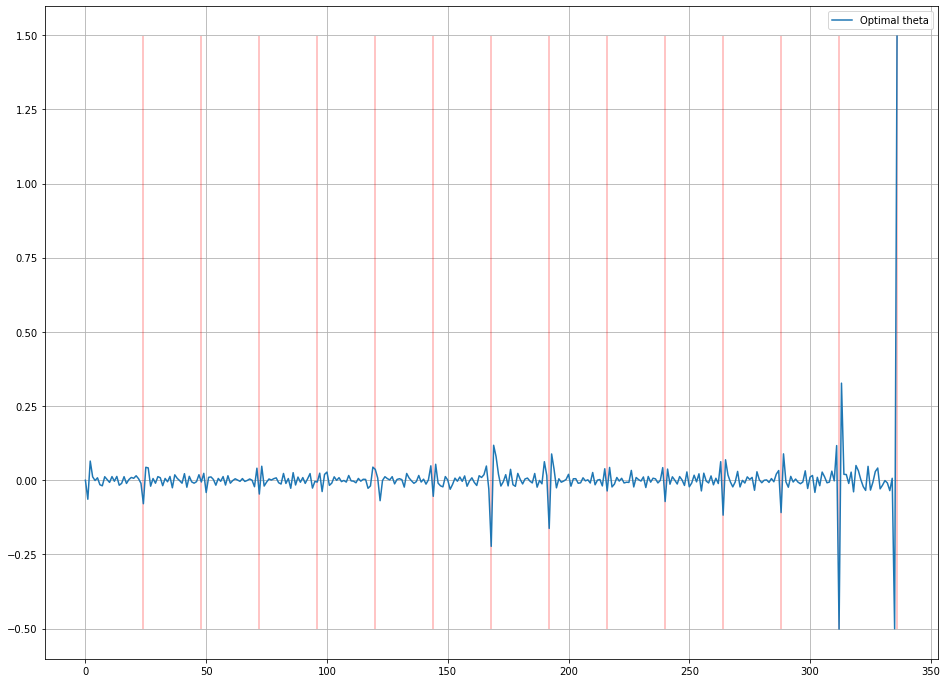

In [174]:
plt.figure(figsize=(16,12))
plt.plot(theta_opt, label='Optimal theta')
for i in range(14):
  plt.vlines(24.0*(i+1),theta_opt.min(),theta_opt.max(),alpha = 0.3,colors='r') #하루를 표시하기 위한 수직선
plt.legend()
plt.grid()
plt.show()

미래의 전력량은 바로 전 4일 가량 , 일주일전, 2주일전을 통해 추정이 가능하다. 이중 1,2,7일전 전력량이 전력량 예측에 가장 큰 영향을 준다.

**(Problem 5)** Report the train RMSE. This numer being small implies that your model works well on the train set $X_\text{train}$ and $y_\text{train}$. This should be natural since your model is chosen to do so.

In [175]:
train_RMSE = np.linalg.norm(X_train.dot(theta_opt)-Y_train)/((n_train)**0.5)

print(train_RMSE) #적은 RMSE --> 모델이 훈련 데이터 세트를 잘 반영한다.

0.041714514022022406


**(Problem 6)** Report the validation RMSE. This number is generally larger than the train RMSE. This numer being small (slightly larger than the train RMSE) implies that your model works well on the validation set $X_\text{valid}$ and $y_\text{valid}$. **Actually this is what you really want**, since it is saying that your model works pretty well even on unseen data (the validation set).

In [176]:
valid_RMSE = np.linalg.norm(X_valid.dot(theta_opt)-Y_valid)/(n_valid**0.5)

print(valid_RMSE) ##적은 RMSE --> 훈련된 모델이 새로운 모델에도 잘 작동한다.(과대적합 X)

0.04871335836107259


**(Problem 7)** Using the optimal parameter vectors you obtained from above, predict the future power demand for the next 7 days ("future"' of course means the hours after the last data point...). Present the plot extending the last 2 weeks' data with your one week prediction. When in the next week do you anticipate that the peak power consumption in California occurs?


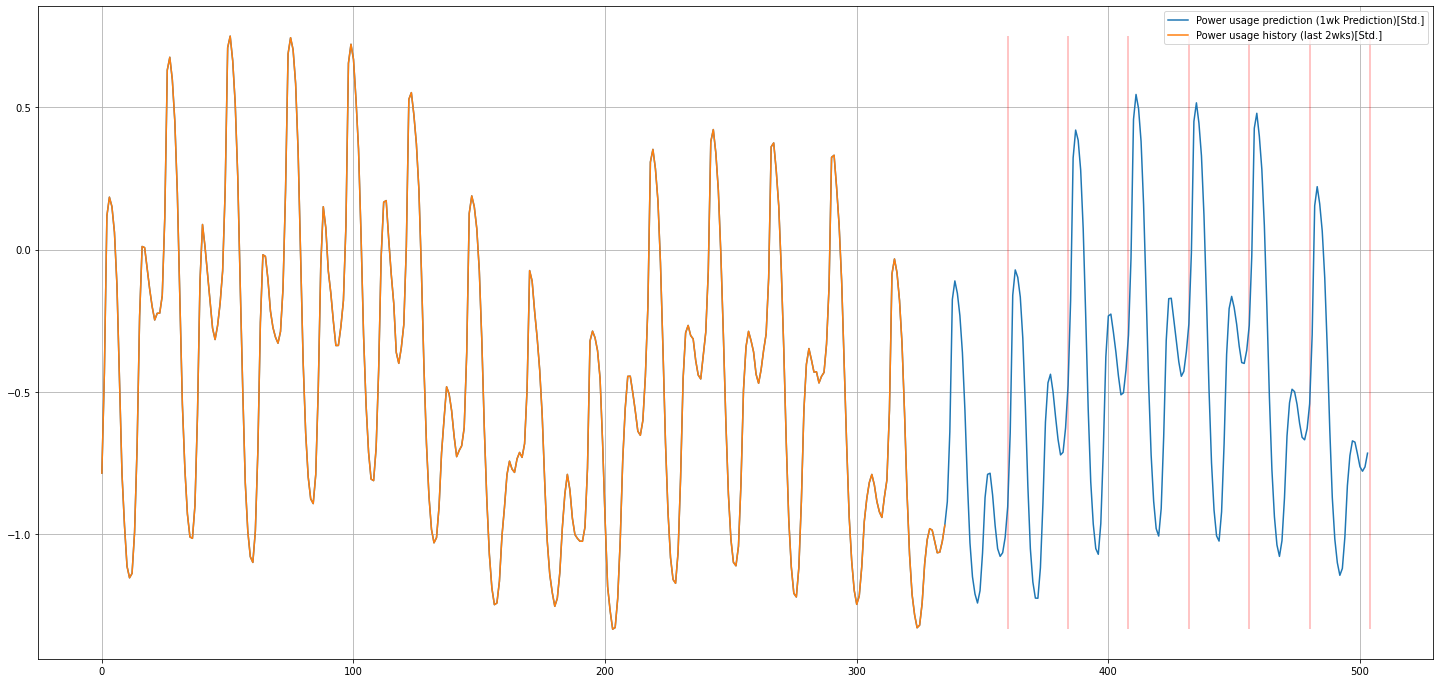

In [177]:
week = 24*7

z_predict = np.ones(week)

for i in range(week):
  if i==0:
    x = np.hstack((1,z[-h+i:])) #x 생성
  else :
    x = np.hstack((1,z[-h+i:],z_predict[:i]))  #예측 추가, 기존 것 제거해 새로운 x
  z_predict[i]=x.dot(theta_opt)

z_new=np.hstack((z[-h:],z_predict)) #기존+예측

plt.figure(figsize=(25,12))
plt.plot(z_new, label='Power usage prediction (1wk Prediction)[Std.]') #순서 영향 주의.
plt.plot(z[-h:], label='Power usage history (last 2wks)[Std.]')
for i in range(7):
  plt.vlines(24.0*(i+15),z_new.min(),z_new.max(),alpha = 0.3,colors='r') #예측 시작일로부터 1일 지날 때마다 표시
plt.legend()
plt.grid()
plt.show()

세번째 빨간줄(기준일로부터 1일 마다 빨간줄)이 나타난 3일 후에 피크 전력이 발생할 것으로 예상된다.